In [ ]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

print(f'PATH_ROOT: {os.getenv("PATH_ROOT")}')
# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-paper')  # Clean, professional style
plt.rcParams.update({
    'font.family': 'serif',  # Use serif fonts
    'font.serif': ['Arial'],  # Use Times New Roman
    'font.size': 10,         # Readable font size
    'axes.linewidth': 1.0,   # Thicker axes lines
    'axes.labelsize': 10,    # Size for axis labels
    'xtick.labelsize': 10,    # Size for x-tick labels
    'ytick.labelsize': 10,    # Size for y-tick labels
})


In [2]:
# Load ze segments
import pandas as pd 
segments_dir = os.getenv("PATH_ROOT") + "/data/hourly"
segments_df = pd.read_csv(segments_dir + "/1717848000.csv")
# column names: id	from_time	to_time	from_lat	from_lon	to_lat	to_lon	from_alt	to_alt	from_speed	to_speed
# segments_df.head()

from MARTINI.airspace.traffic_fir import filter_segments_by_fir
segments_df = filter_segments_by_fir(segments_df, 'LFMM')
segments_df.head()


,id,from_time,to_time,from_lat,from_lon,to_lat,to_lon,from_alt,to_alt,from_speed,to_speed
23,4caca2FPO756,1.717849e+09,1.717850e+09,41.417340,4.595479,42.293220,4.859023,6096.00,4610.10,0.167219,0.156344
24,4caca2FPO756,1.717850e+09,1.717851e+09,42.293220,4.859023,43.595627,4.860364,4610.10,1630.68,0.156344,0.103018
25,4caca2FPO756,1.717851e+09,1.717851e+09,43.595627,4.860364,43.603638,4.975274,1630.68,1318.26,0.103018,0.059063
26,4caca2FPO756,1.717851e+09,1.717851e+09,43.603638,4.975274,43.489845,5.138528,1318.26,449.58,0.059063,0.000000
30,39dd42CCM71EU,1.717848e+09,1.717848e+09,46.603271,3.192868,46.486553,3.256073,10957.56,11049.00,0.230825,0.236232


In [3]:
# Convert to euclidean coordinates
from MARTINI.airspace.geo import geo_to_xy, create_local_projection
import numpy as np

# Create local projection based on average coordinates
avg_lat = segments_df['from_lat'].mean()
avg_lon = segments_df['from_lon'].mean()
transformer = create_local_projection(avg_lat, avg_lon)

# Convert coordinates using vectorized operations
segments_df[['from_x', 'from_y']] = np.array([
    geo_to_xy(lat, lon, transformer) 
    for lat, lon in zip(segments_df['from_lat'], segments_df['from_lon'])
])

segments_df[['to_x', 'to_y']] = np.array([
    geo_to_xy(lat, lon, transformer) 
    for lat, lon in zip(segments_df['to_lat'], segments_df['to_lon'])
])

# Convert to kilometers for better readability
for col in ['from_x', 'from_y', 'to_x', 'to_y']:
    segments_df[col] = segments_df[col] / 1000

print("Coordinates converted to local projection (units: kilometers)")

Coordinates converted to local projection (units: kilometers)


In [4]:
# Create the segments object for distance matrix computation
import numpy as np
# Sample 1000 random segments
sampled_df = segments_df.sample(n=1000, random_state=42)

# Convert to list of segment tuples
trajectories = []
for _, row in sampled_df.iterrows():
    # Create start and end points as 2D numpy arrays
    start_point = np.array([row['from_x'], row['from_y']])
    end_point = np.array([row['to_x'], row['to_y']])
    trajectories.append((start_point, end_point))


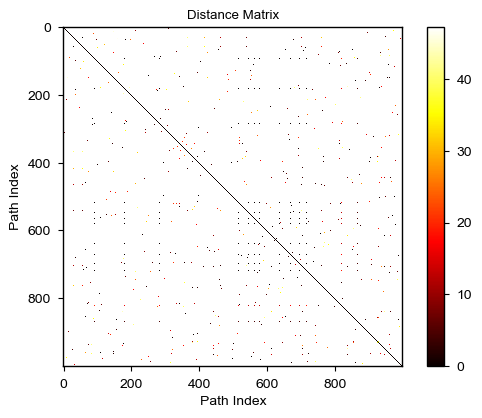

In [5]:
from matplotlib import pyplot as plt
import numpy as np
# Compute the distance matrix
from ALPHA.dirichlet.trajclus_features import compute_distance_matrix
from ALPHA.dirichlet.hdbs import perform_clustering
from ALPHA.dirichlet.trajclus_features import compute_segment_features_auto

distance_matrix = compute_distance_matrix(trajectories,
                                          allow_cutoff=True, max_distance=40,
                                          max_dt=0.2)
# Visualize the distance matrix
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()



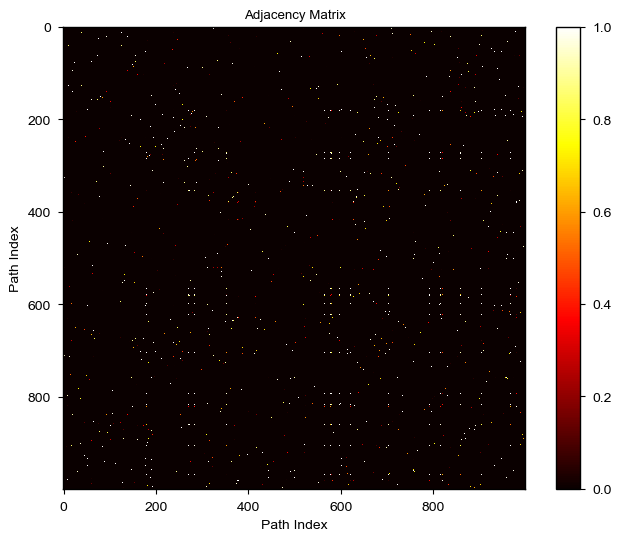

In [6]:
# Replace inf values in distance matrix with zeros in similarity calculation
similarity_matrix = np.copy(distance_matrix)
similarity_matrix[np.isinf(similarity_matrix)] = 0


# Convert distance matrix to similarity matrix using Gaussian kernel
sigma = np.mean(similarity_matrix[similarity_matrix > 0])  # Can be tuned based on your needs
# Only apply exponential transformation to non-zero values
nonzero_mask = similarity_matrix != 0
similarity_matrix[nonzero_mask] = np.exp(-similarity_matrix[nonzero_mask]**2 / (2 * sigma**2))
adjacency_matrix = similarity_matrix

# Visualize the adjacency matrix
plt.figure(figsize=(8, 6))
plt.imshow(adjacency_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Adjacency Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()

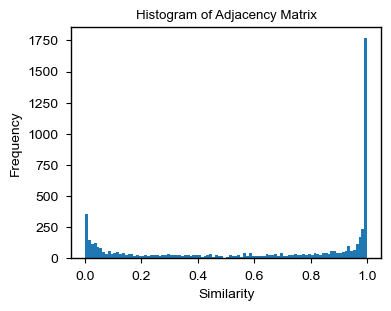

In [7]:
# Plot the adjacency matrix histogram
plt.figure(figsize=(4, 3))
plt.hist(adjacency_matrix[adjacency_matrix > 0], bins=100)
plt.title('Histogram of Adjacency Matrix')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


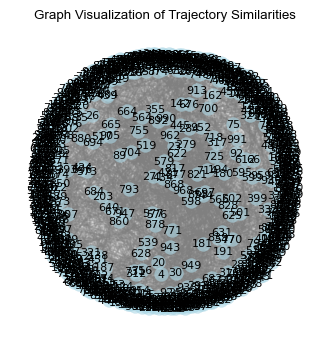

In [8]:
import networkx as nx

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Set up the plot
plt.figure(figsize=(4, 4))

# Calculate node positions using a spring layout
# You can experiment with different layout algorithms like spring_layout, kamada_kawai_layout, circular_layout
pos = nx.spring_layout(G, k=1, iterations=50)

# Draw the network
# Nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                      node_size=100, alpha=0.6)

# Edges - only draw edges with weight above a threshold to reduce clutter
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
threshold = 0  # You can adjust this threshold
edges = [(u, v) for (u, v) in G.edges() if G[u][v]['weight'] > threshold]
nx.draw_networkx_edges(G, pos, edgelist=edges, 
                      alpha=0.2, edge_color='gray')

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('Graph Visualization of Trajectory Similarities')
plt.axis('off')
plt.show()

In [9]:
from IPython.display import Markdown, display

from ALPHA.dirichlet.leiden import leiden_community_detection
communities, quality = leiden_community_detection(adjacency_matrix,
                                                  resolution=1.0,
                                                  n_iterations=200)
    
print(f"Found {len(np.unique(communities))} communities")
print(f"Partition quality: {quality}")

# Create a DataFrame with community sizes
community_sizes = pd.DataFrame({
    'Community': range(len(np.unique(communities))),
    'Number of Trajectories': [np.sum(np.array(communities) == i) for i in range(len(np.unique(communities)))]
})

# Display first 20 rows as a table
display(Markdown(f"## Community Sizes\n{community_sizes.head(10).to_markdown()}"))

most_frequent_communities = community_sizes['Number of Trajectories'].nlargest(10).index.tolist()

Found 169 communities
Partition quality: 6391.500157236071


## Community Sizes
|    |   Community |   Number of Trajectories |
|---:|------------:|-------------------------:|
|  0 |           0 |                       71 |
|  1 |           1 |                       61 |
|  2 |           2 |                       61 |
|  3 |           3 |                       55 |
|  4 |           4 |                       53 |
|  5 |           5 |                       49 |
|  6 |           6 |                       49 |
|  7 |           7 |                       40 |
|  8 |           8 |                       39 |
|  9 |           9 |                       38 |

In [10]:
# Load the FIR
from MARTINI.airspace.traffic_fir import get_fir_polygon
fir_polygon = get_fir_polygon('LFMM') # Marseille

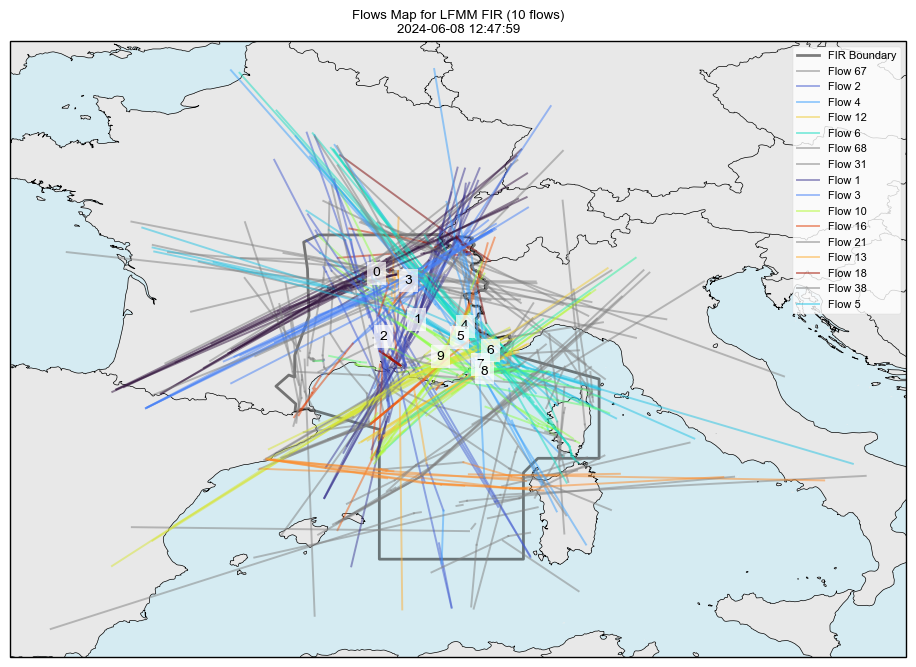

In [19]:
# Create plot with cartopy projection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot the FIR polygon
fig, ax = plt.subplots(figsize=(12, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)


x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=2, label='FIR Boundary', 
        transform=ccrs.PlateCarree())

# Plot sampled segments with community colors
colors = plt.cm.turbo(np.linspace(0, 1, 20))  # Get unique color for each community
for i, (idx, seg) in enumerate(sampled_df.iterrows()):
    community_id = communities[i]
    if community_id < 20:  # First 20 communities get distinct colors
        color = colors[community_id]
    else:  # Rest get gray
        color = 'gray'
    ax.plot([seg['from_lon'], seg['to_lon']], 
            [seg['from_lat'], seg['to_lat']], 
            color=color, alpha=0.5, transform=ccrs.PlateCarree(),
            label=f'Flow {community_id}' if (i == 0 or communities[i] != communities[i-1]) and (i < 20) else "")
    
# Add text annotations for each community
communities_np = np.array(communities)
for community_id in range(min(20, len(most_frequent_communities))):
    # Get segments for this community
    community_segments = sampled_df[communities_np == community_id]
    
    if len(community_segments) > 0:
        # Calculate mean position for annotation
        mean_lon = community_segments[['from_lon', 'to_lon']].values.mean()
        mean_lat = community_segments[['from_lat', 'to_lat']].values.mean()
        
        # Add text annotation
        ax.text(mean_lon, mean_lat, f'{community_id}',
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                ha='center', va='center')

    
# Create legend with unique labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


# Convert timestamp to readable datetime
timestamp = sampled_df.iloc[0]["from_time"]
datetime_str = pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d %H:%M:%S')

plt.title(f'Flows Map for LFMM FIR ({len(most_frequent_communities)} flows)\n{datetime_str}')

plt.grid(True)
plt.show()


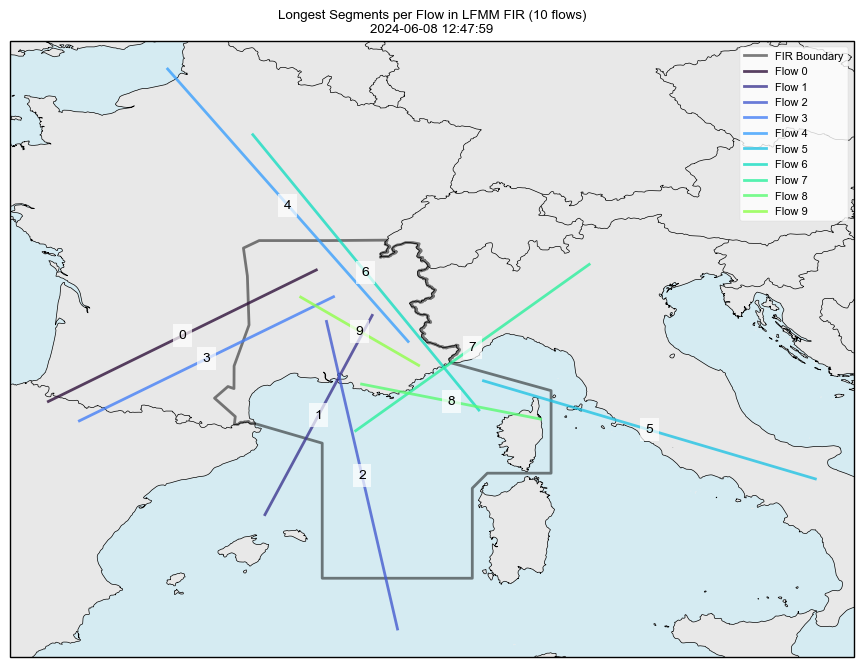

In [20]:
# ... existing imports and FIR setup ...

# Plot the FIR polygon
fig, ax = plt.subplots(figsize=(12, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add natural features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

# Plot FIR boundary
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=2, label='FIR Boundary', 
        transform=ccrs.PlateCarree())

# Find longest segment for each community
colors = plt.cm.turbo(np.linspace(0, 1, 20))
communities_np = np.array(communities)

for community_id in range(min(20, len(most_frequent_communities))):
    # Get segments for this community
    community_mask = communities_np == community_id
    community_segments = sampled_df[community_mask]
    
    if len(community_segments) > 0:
        # Calculate segment lengths
        segment_lengths = np.sqrt(
            (community_segments['to_lon'] - community_segments['from_lon'])**2 +
            (community_segments['to_lat'] - community_segments['from_lat'])**2
        )
        
        # Get the longest segment
        longest_idx = segment_lengths.idxmax()
        longest_segment = community_segments.loc[longest_idx]
        
        # Plot the longest segment
        color = colors[community_id]
        ax.plot([longest_segment['from_lon'], longest_segment['to_lon']], 
                [longest_segment['from_lat'], longest_segment['to_lat']], 
                color=color, alpha=0.8, linewidth=2,
                transform=ccrs.PlateCarree(),
                label=f'Flow {community_id}')
        
        # Add text annotation at midpoint
        mid_lon = (longest_segment['from_lon'] + longest_segment['to_lon']) / 2
        mid_lat = (longest_segment['from_lat'] + longest_segment['to_lat']) / 2
        
        ax.text(mid_lon, mid_lat, f'{community_id}',
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'),
                ha='center', va='center')

# Create legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Convert timestamp to readable datetime
timestamp = sampled_df.iloc[0]["from_time"]
datetime_str = pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d %H:%M:%S')

plt.title(f'Longest Segments per Flow in LFMM FIR ({len(most_frequent_communities)} flows)\n{datetime_str}')

plt.grid(True)
plt.show()